# Ćwiczenie 4 - przecinanie się odcinków
### Aby uruchomić program, należy zainstalować moduł `sortedcontainers` za pomocą komendy `pip install sortedcontainers`

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posia+da metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Rozwiązanie
### Pkt 1 - przygotowanie punktów
#### Klasy używane w ćwiczeniu
##### Linia:
Klasa przechowuje startowy punkt (o mniejszyej współrzędnej x), końcowy, oraz współrzędne liniowe a oraz b (z równania funkcji liniowej y = ax+b), które pomagają w znalezieniu ewentualnego przecięcia między liniami oraz do posegregowania ich.

In [3]:
class Line:
    lineID = 0
    def __init__(self, points):
        start, end = points
        if start[0] > end[0]: start, end = end, start

        self.start = start
        self.end = end
        if start[0] - end[0] != 0:
            self.a = (start[1] - end[1]) / (start[0] - end[0])
            self.b = start[1] - self.a * start[0]

        self.currentY = start[1]
        self.lineID = Line.lineID
        Line.lineID += 1

    def __str__(self):
        return f"{self.start}, {self.end}"

    def setCurrY(self, x):
        self.currentY = self.a * x + self.b

    def __gt__(self, other):
        return self.currentY > other.currentY

    def __hash__(self):
        return hash(self.lineID)

#### Rysowanie własnych odcinków

Funkcja `getLines(plot)` przyjmuje obiekt klasy `Plot`. Przechwytuje wszystkie narysowane na nim linie oraz zwraca listę obiektów klasy `Line`

<IPython.core.display.Javascript object>


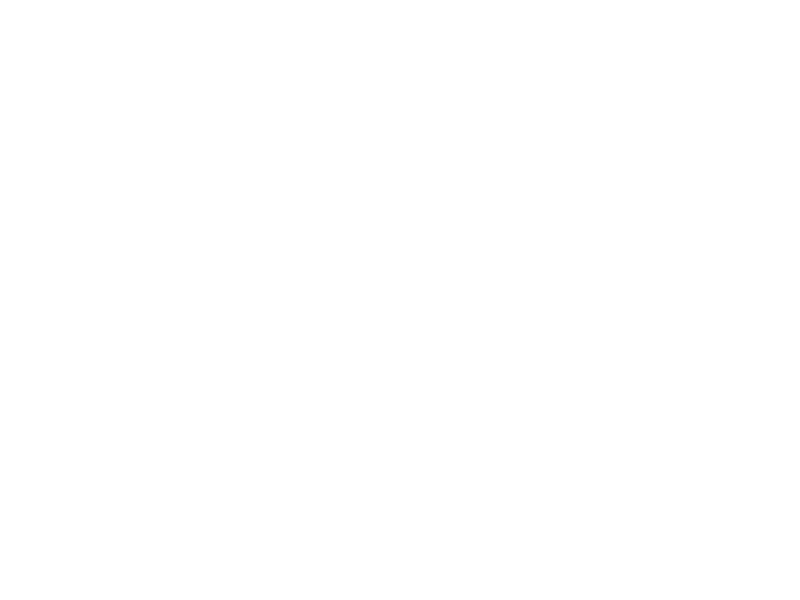

In [4]:
%matplotlib notebook
#Dodaj tutaj linie
plot1 = Plot()
plot1.draw()

In [5]:
def getLines(plot):
    linesCollection = plot.get_added_lines() #obiekt klasy LinesCollection
    if linesCollection == []: return None
    return [Line(line) for line in linesCollection[0].lines]    #zwracamy listę obiektów klasy Line

drawnLines = getLines(plot1)
if drawnLines is not None:
    for line in drawnLines:
        print(line)

### Zestawy punktów  z zajęć

In [6]:
linieZZajec = [[ [(0.08583669354838713, 0.7309640660005459), (1.0106350806451614, 0.3703635758044674)],
[(-0.013961693548387083, 0.23892975227505558), (0.9795866935483871, 0.8354371052162322)],
[(0.12797379032258066, 0.48831700717701637), (0.3519657258064517, 0.5388684777652517)],
[(0.5959173387096774, 0.3231822032554477), (0.811038306451613, 0.933169948353487)],
[(0.7533770161290323, 0.2658905365887811), (0.9307963709677419, 0.933169948353487)]],
                                                                                           #set 3 - zajęcia - pierwszy zbiór
 [[(0.20914315869731293, 0.8017361248240753), (0.8877721909553774, 0.6366013209025065)],
[(0.15369961031021612, 0.4782067130593693), (0.7857560619231193, 0.34003269345152615)],
[(0.1492641264392484, 0.6736723993338791), (0.7791028361166678, 0.48831700717701637)],
[(0.2867641264392484, 0.2793709287456438), (0.4198286425682807, 0.9635008307064283)],
[(0.45974799740699035, 0.23892975227505558), (0.6172076748263452, 0.9399101444319184)],
[(0.7192238038586033, 0.2288194581574085), (0.8057157393424742, 0.9264297522750558)]]]

#### Filtrowanie i losowanie punktów
*Filtrowanie*: Usunięcie pionowych odcinków oraz posiadających tę samą współrzędną x na końcach. 

In [7]:
def filterLines(lines):  # lines - list consisting of Line objects
    def removeSameXs(arr, atr):
        i = 0
        while i < len(arr)-1:
            x1 = getattr(arr[i], atr)[0]
            x2 = getattr(arr[i+1], atr)[0]
            if x1 == x2:
                del arr[i]
            else:
                i += 1

    def removeDuplicates(arr1, arr2):
        i, j = 0, 0
        n = len(arr1)  # both arrays are of the same length
        while i < n and j < n:
            x1, x2 = arr1[i].start[0], arr2[j].end[0]
            if x1 == x2:
                del arr2[j]
            elif x1 < x2:
                i += 1
            else:
                j += 1

    lines = list(filter(lambda line: line.start[0] != line.end[0], lines))  # delete vertical lines


    sortedByXstart = sorted(lines, key=lambda line: line.start[0])  # sort by x coordinate of the first point in line
    sortedByXend = sorted(lines, key=lambda line: line.end[0])  # sort by x coordinate of the second point in line

    removeSameXs(sortedByXstart, "start")  #deleting only the lines that have the same x value on start
    removeSameXs(sortedByXend, "end")      #deleting only the lines that habe the same x value on end

    removeDuplicates(sortedByXstart, sortedByXend)

    s1, s2 = set(sortedByXstart), set(sortedByXend)
    return list(s1.intersection(s2))

*Losowanie*: Losowanie n punktów z zadanego zakresu linii 2D

Procedura obiera liczbę linii do narysowania oraz 4 liczby będące granicami obszaru 2D, na którym rysowane są punkty. Funkcja zwraca listę długości n zawierającą obiekty klasy Line

In [8]:
from random import uniform

def randomLines(x1, x2, y1, y2, n):
    assert x1 != x2 and y1 != y2,  "Wrong atribute: the area of given rectangle is 0"
    x_min, x_max, y_min, y_max = min(x1, x2), max(x1, x2), min(y1, y2), max(y1, y2)
    result = []
    for _ in range(n):
        p1 = (uniform(x_min, x_max), uniform(y_min, y_max))
        p2 = (uniform(x_min, x_max), uniform(y_min, y_max))
        newLine = Line((p1,p2))
        result.append(newLine)
    return result

In [9]:
listOfLines = [[(-1, 0), (-1, -1)],
               [(0,0), (1,1)],
               [(1,0), (2,1)],
               [(0.5,0), (1, -1)],
               [(3,1), (4,0)]]
lineObj = [Line(line) for line in listOfLines]
result = filterLines(lineObj)
for res in result:
    print(res)
print()

randLines = randomLines(0, 1, 0, 1, 5)
for randLine in randLines:
    print(randLine)

(1, 0), (2, 1)
(3, 1), (4, 0)

(0.2816314791547675, 0.1734219100353016), (0.9134229312486691, 0.25871057431276756)
(0.4610179393165543, 0.0166930814569054), (0.9304992850862727, 0.23537208749568772)
(0.011174086557952045, 0.19759492345385676), (0.49445669534423464, 0.45547838161545395)
(0.03855870884024959, 0.041635964937051906), (0.8363358178390675, 0.4798816733723845)
(0.8674190771952395, 0.920435736223981), (0.8902306810744333, 0.19290534808242799)


### Zapis do pliku `.json`

In [10]:
def toJson(lines):      #line objects
    with open("lines.json", 'w') as file:
        file.write(js.dumps([{"line":(line.start, line.end)} for line in lines]))

### Odczyt z pliku `.json`

In [11]:
def fromJson(json_file_name):
    with open(json_file_name, 'r') as file:
        jsonList = js.loads(file.read())
    return list(map(lambda x: Line(x['line']), [elem for elem in jsonList]))

#### Test zapisu i odczytu

In [12]:
listOfLines = [[(-1, 0), (-1, -1)],
               [(0,0), (1,1)],
               [(1,0), (2,1)],
               [(0.5,0), (1, -1)],
               [(3,1), (4,0)]]
listObj = [Line(line) for line in listOfLines]

toJson(listObj)
spam = fromJson("lines.json")
for el in spam:
    print(el)

[-1, 0], [-1, -1]
[0, 0], [1, 1]
[1, 0], [2, 1]
[0.5, 0], [1, -1]
[3, 1], [4, 0]


## Punkt 2
Implementacja algorytmu zamiatającego, sprawdzającego, czy przynajmniej jedna para puktów się przecina

### Klasa `Event` do rejestracji zdarzeń

In [13]:
class Event:
    def __init__(self, position, line):
        self.position = position    #point (x,y)  - tuple
        self.line = line            #Line class object
        
        
    def __gt__(self, other):
        return self.position[0] > other.position[0]

In [14]:
def updateSweepLine(T, currX):    
    linesList = list(T)
    for i in range(len(linesList)):
        linesList[i].setCurrY(currX)
    return SortedSet(linesList)
        

### Funkcja sprawdzająca, czy dwie linie się przecinają
Jeżeli mamy dwa odcinki - AB i CD - to przecinają się one wtw gdy wyznaczniki punktów ABC i ABD mają przeciwny znak oraz wyznaczniki CDA i CDB mają przeciwny znak. (Pomijamy sytuację, w której wierzchołki się stykają - tego typu odcinki usunęliśmy w punkcie pierwszym)

In [15]:
def det3x3(a,b,c):
    s1 = a[0]*b[1] + b[0]*c[1] + c[0]*a[1]
    s2 = a[1]*b[0] + b[1]*c[0] + c[1]*a[0]
    return s1 - s2

def det(a,b,c):
    eps = 10**(-13)

    det = det3x3(a, b, c)   # computing the determinant of given interval and the point c
    if det < -eps:           # c is clockwise to the interval - it's on its right 
        return -1
    elif det > eps:          # c is counterclockwise to the interval - it's on its left
        return 1
    else:                    # c is within the "epsilon range" - collinear
        return 0
    

def checkIfLinesIntersect(line1, line2):
    if line1 is None or line2 is None or line1.a == line2.a:
        return False

    a, b, c, d = line1.start, line1.end, line2.start, line2.end
    detABC, detABD, detCDA, detCDB = det(a, b, c), det(a, b, d), det(c, d, a), det(c, d, b)

    return (detABC * detABD <= 0 and detCDA * detCDB <= 0)


### Funkcja sprawdzająca, czy którekolwiek punkty się przecinają
Zastosowane struktury- 

Q - struktura zdarzeń - kolejka priorytetowa wypełniona obiektami typu Event

T - struktura stanu - zbió aktywnych odcinków, uporządkowanych wg współrzędnej y - zaimplementowana jako `sortedset()`, który opiera się na implementacji drzewa czerwono-czarnego

In [16]:
from queue import PriorityQueue
from sortedcontainers import SortedSet

def doLinesCross(lines):
    def initQueue(lines):
        res = PriorityQueue()
        for line in lines:
            res.put(Event(line.start, line))
            res.put(Event(line.end, line))
        return res

    def getPrevAndSucc(T, s):
        s_index = T.index(s)
        prev_ind, succ_ind = s_index - 1, s_index + 1

        prev, succ = None, None
        if prev_ind >= 0: prev = T[prev_ind]    #if prev_ind < 0 - prev will be None
        if succ_ind < len(T): succ = T[succ_ind]
        return prev, succ

    
    Q = initQueue(lines)
    T = SortedSet()
    while not Q.empty():
        event = Q.get()
        s = event.line
        currX, currY = event.position
        
        if event.position == s.start:
            T.add(s)
            T = updateSweepLine(T, currX)
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(s, prev) or checkIfLinesIntersect(s, succ):
                return True
        else:
            prev, succ = getPrevAndSucc(T, s)
            T = updateSweepLine(T, currX)
            if checkIfLinesIntersect(prev, succ):
                return True
            T.remove(s)

    return False

In [17]:
listOfLines = [[(-1, 0), (-1, -1)],
               [(0,0), (1,1)],
               [(1,0), (2,1)],
               [(0.5,0), (1, -1)],
               [(3,1), (4,0)]]
lineObj = [Line(line) for line in listOfLines]
lines = filterLines(lineObj)

print(doLinesCross(lines))

False


## Punkt 4
### Wizualizator
Wizualizator pokazuje linie oraz miejsce, w którym znajduje się miotła. Dodatkowo, aby umożliwić wizualizację kolejnego algorytmu, pokazuje również zdarzenia z kolejki Q oraz linie znajdujące się w strukturze T zaznaczane są innym kolorem. 

In [18]:
class Visualizer:
    def _findSweepLineRange(self, lines):
        minY = maxY = lines[0].start[1]   #y-coordinate of the start of the first line
        for line in lines:
            y1, y2 = line.start[1], line.end[1]
            if y1 < minY: 
                minY = y1
            if y2 < minY: 
                minY = y2   
            if y1 > maxY: 
                maxY = y1
            if y2 > maxY: 
                maxY = y2
        return (minY, maxY)
            
    
    def __init__(self, lines, queuePoints, setPoints):
        self.__colors = {"sweep":"fuchsia",
                         "events":["aquamarine", "mediumturquoise", "teal"],
                         "lines":["lightskyblue", "dodgerblue"]}  #[0] - normal lines, [1] - linesInSet
        self.queue =  queuePoints  #points in queue - queue[0] - starts, queue[1] - ends, queue[2] - intersections
        self.linesInSet = setPoints          #line in T structure
        self.allLines = [(line.start, line.end) for line in lines]  #storing them this way makes it easier to visualize them later
        self.sweepLineHeight = self._findSweepLineRange(lines) #y coordinates of the sweep line
        
        self.scenes = []
        
        
    def _makeSweepLine(self, x):
        y1, y2 = self.sweepLineHeight
        return [((x, y1), (x, y2))] #two tuples inside a tuple inside a list that will be inside a LinesCollection object
    
    def makeScene(self, x):
        points = [PointsCollection(self.queue[i][:], color = self.__colors["events"][i]) for i in range(3)]
        lines = [LinesCollection(self.allLines, color=self.__colors["lines"][0]),
                LinesCollection(self.linesInSet[:], color=self.__colors["lines"][1]),
                LinesCollection(self._makeSweepLine(x), color=self.__colors["sweep"])]
        self.scenes.append(Scene(points, lines))
        
    def getScenes(self):
        return self.scenes
    

In [19]:
def doLinesCrossShow(lines):
    def initQueue(lines, qPoints):
        res = PriorityQueue()
        for line in lines:
            res.put(Event(line.start, line))
            res.put(Event(line.end, line))
            qPoints[0].append(line.start)
            qPoints[1].append(line.end)
        return res

    def getPrevAndSucc(T, s):
        s_index = T.index(s)
        prev_ind, succ_ind = s_index - 1, s_index + 1

        prev, succ = None, None
        if prev_ind >= 0: prev = T[prev_ind]    #if prev_ind < 0 - prev will be None
        if succ_ind < len(T): succ = T[succ_ind]
        return prev, succ

    qPoints = [[] for _ in range(3)]
    sPoints = []
    vs = Visualizer(lines, qPoints, sPoints)
    minX = min([line.start[0] for line in lines])
    vs.makeScene(minX)
    
    Q = initQueue(lines, qPoints)
    T = SortedSet()
    vs.makeScene(minX)
    
    while not Q.empty():
        event = Q.get()
        s = event.line
        currX, currY = event.position
        
        if event.position == s.start:
            qPoints[0].remove(event.position)
            T.add(s)
            T = updateSweepLine(T, currX)
            sPoints.append((s.start, s.end))
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(s, prev) or checkIfLinesIntersect(s, succ):
                vs.makeScene(currX)
                return vs.getScenes()
        else:
            qPoints[1].remove(event.position)
            T = updateSweepLine(T, currX)
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(prev, succ):
                vs.makeScene(currX)
                return vs.getScenes()
            T.remove(s)
            sPoints.remove((s.start, s.end))
        vs.makeScene(currX)

    return vs.getScenes()

<IPython.core.display.Javascript object>


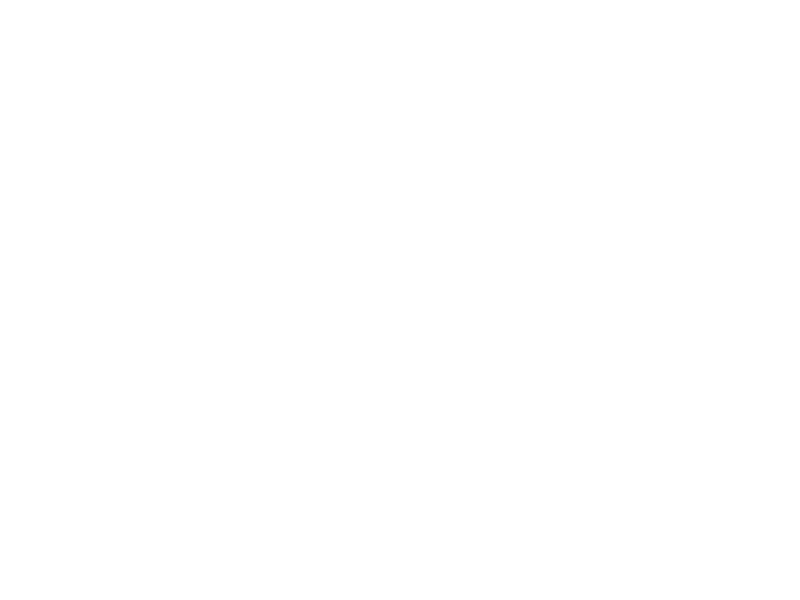

In [20]:
listOfLines = [[(5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)],
[(5.27530167768322, 9.21545885591907), (9.457173710897276, 5.5762014809850875)],
[(2.4492030280207677, 6.353353413718593), (7.768266091349684, 2.3784704051570724)],
[(0.8003788674291379, 6.0536614701705895), (9.304761440956957, 1.1987537979704943)],
[(3.7372765510268415, 0.5200922875894587), (9.356755605600354, 3.263738392338975)]]
lineObj = [Line(line) for line in listOfLines]
lines = filterLines(lineObj)


plot = Plot(doLinesCrossShow(lines))
plot.draw()

## Punkt 5
### Testy na różnych zestawach danych

In [21]:
lineSets = [[[(-1, 0), (-1, -1)],[(0,0), (1,1)],[(1,0), (2,1)],[(0.5,0), (1, -1)]],   #set 0 - testing deleting invalid lines
            [[(-1, 0), (2, -1)], [(1, 3), (3, 4)], [(0, 2), (4, 1)]],   #set 1 - without intersection - test of structures
            [[(-1, 0), (2, -1)], [(1, 3), (3, 4)], [(0, 2), (5, 1)], [(4, 1), (6,3)]]]  #set 2 - with intersection - test of detecting intersection

lineClassList = [ filterLines([Line(line) for line in listOfLines]) for listOfLines in lineSets]

<IPython.core.display.Javascript object>


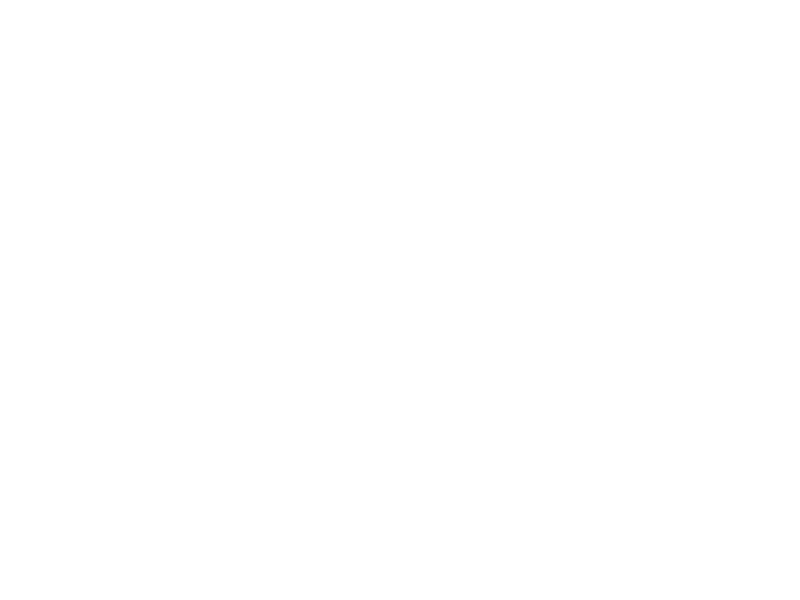

In [22]:
plot = Plot(doLinesCrossShow(lineClassList[0]))
plot.draw()

<IPython.core.display.Javascript object>


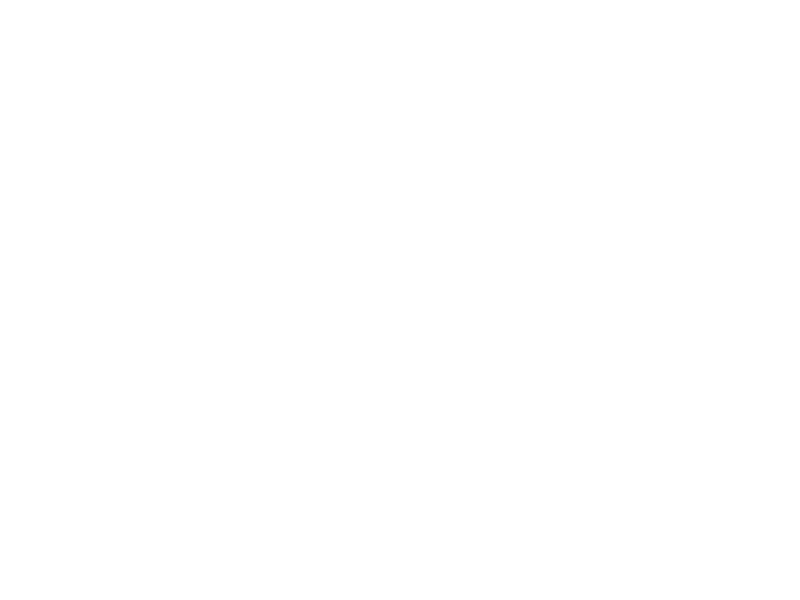

In [23]:
plot = Plot(doLinesCrossShow(lineClassList[1]))
plot.draw()

<IPython.core.display.Javascript object>


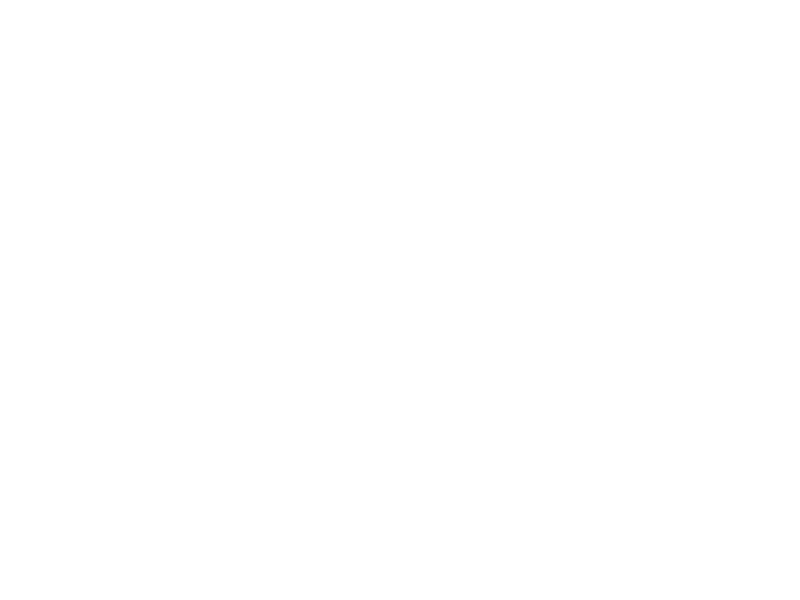

In [24]:
plot = Plot(doLinesCrossShow(lineClassList[2]))
plot.draw()

## Punkt 6
### Modyfikacja algorytmu tak, aby zwracał:
a) liczbę punktów przecięcia

b) punkty przecięcia

c) przecięte odcinki

#### Funkcja obliczająca punkt przecięcia się odcinków

In [25]:
def intersectionPoint(line1, line2):
    a1, b1, a2, b2 = line1.a, line1.b, line2.a, line2.b
    x = (b2-b1)/(a1-a2)
    y = a1*x + b1
    return (round(x, 12), round(y, 12))

#### Funkcja sprawdzająca, czy punkt już został wcześniej wykryty

In [26]:
def wasDetected(detectedEvents, line1, line2):
    return (line1, line2) in detectedEvents.keys() or (line2, line1) in detectedEvents.keys()

#### Funkcja dodająca element do kolejki i aktualizująca listę przecięć
Punkty są dodawane na bazie hashu dwóch linii. Jest to jednoznaczne, ponieważ hash pojedynczej linii wyliczany jest na bazie jej unikatowego numeru ID (`self.lineID`)

In [27]:
def addToQueue(queue, detectedIntersections, line1, line2):
    newEvent = Event1(intersectionPoint(line1, line2), [line1, line2])
    queue.put(newEvent)
    detectedIntersections[(line1, line2)] = newEvent

#### Zmodyfikowana klasa `Event` (nazwa zmieniona na `Event1`)
Klasa ta dodatkowo determinuje typ zdarzenia na podstawie liczby zapamiętanych linii oraz ich typu. Posiada również odpowiednie parametry: `.line` dla końców odcinka, `.prevLine` oraz `.succLine` dla przecięć (pierwszy poprzedza drugi w strukturze drzewa)

In [28]:
class Event1:
    def __init__(self, position, lines):
        assert 0 < len(lines) <= 2, "Error: wrong number of lines"
        self.position = position
        self.eventType = None
        self.prevLine = None
        self.succLine = None
        self.line = None
        
        if len(lines) == 2:
            self.eventType = "intersection"
            assert lines[0] < lines[1], "Error: lines were put in wrong order"
            self.prevLine = lines[0]
            self.succLine = lines[1]
        else:
            self.line = lines[0]
            if self.line.start == self.position:
                self.eventType = "start"
            else:
                self.eventType = "end"
    
    def __gt__(self, other):
        return self.position[0] > other.position[0]

### Funkcja znajdująca przecięcia odcinków

In [29]:
from queue import PriorityQueue
from sortedcontainers import SortedSet

def whereLinesCross(lines):
    def initQueue(lines):
        res = PriorityQueue()
        for line in lines:
            res.put(Event1(line.start, [line]))
            res.put(Event1(line.end, [line]))
        return res

    def getPrev(T, s):
        prev_ind = T.index(s) - 1
        if prev_ind >= 0: return T[prev_ind]
        else:             return None
    
    def getSucc(T, s):
        succ_ind = T.index(s) + 1
        if succ_ind < len(T): return T[succ_ind]
        else:                 return None
    
    def getPrevAndSucc(T, s):
        return getPrev(T,s), getSucc(T,s)
    
    def prepareResult(intersectionsSet):
        eventsList = list(intersectionsSet.values())
        return (len(eventsList),    #number of intersections
                [event.position for event in eventsList],   #intersection points
                [((event.prevLine.start, event.prevLine.end),
                  (event.succLine.start, event.succLine.end)) for event in eventsList])   #intersecting lines
    

    Q = initQueue(lines)
    T = SortedSet()
    
    intersectingEvents = dict()
    while not Q.empty():
        event = Q.get()
        currX, currY = event.position
        
        if event.eventType == "start":
            s = event.line
            T.add(s)
            T = updateSweepLine(T, currX)
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(s, prev) and not wasDetected(intersectingEvents, s, prev):
                addToQueue(Q, intersectingEvents, prev, s)
            if checkIfLinesIntersect(s, succ) and not wasDetected(intersectingEvents, s, succ):
                addToQueue(Q, intersectingEvents, s, succ)

        elif event.eventType == "end":
            s = event.line
            T = updateSweepLine(T, currX)
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(prev, succ) and not wasDetected(intersectingEvents, prev, succ):
                addToQueue(Q, intersectingEvents, prev, succ)
            T.remove(s)

        else:
            linePrev, lineSucc = event.prevLine, event.succLine

            T = updateSweepLine(T, currX + 10 ** (-10))

            newSucc = getSucc(T, linePrev)
            if checkIfLinesIntersect(linePrev, newSucc) and not wasDetected(intersectingEvents, linePrev, newSucc):
                addToQueue(Q, intersectingEvents, linePrev, newSucc)

            newPrev = getPrev(T, lineSucc)
            if checkIfLinesIntersect(newPrev, lineSucc) and not wasDetected(intersectingEvents, newPrev, lineSucc):
                addToQueue(Q, intersectingEvents, newPrev, lineSucc)

    return prepareResult(intersectingEvents)

In [30]:
listOfLines = [[(5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)],
[(5.27530167768322, 9.21545885591907), (9.457173710897276, 5.5762014809850875)],
[(2.4492030280207677, 6.353353413718593), (7.768266091349684, 2.3784704051570724)],
[(0.8003788674291379, 6.0536614701705895), (9.304761440956957, 1.1987537979704943)],
[(3.7372765510268415, 0.5200922875894587), (9.356755605600354, 3.263738392338975)]]
lineObj = [Line(line) for line in listOfLines]
lines = filterLines(lineObj)

intersections = whereLinesCross(lines)

print(intersections[0])
print()
for intersecPoint in intersections[1]:
    print(intersecPoint)
print()
for intersecLine in intersections[2]:
    print(intersecLine)

5

(7.378994091111, 2.298119048864)
(6.301699589477, 2.913115528148)
(6.519895178804, 3.311365591693)
(8.308465636425, 6.575860078491)
(7.679473142193, 2.444824494342)

(((3.7372765510268415, 0.5200922875894587), (9.356755605600354, 3.263738392338975)), ((0.8003788674291379, 6.0536614701705895), (9.304761440956957, 1.1987537979704943)))
(((5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)), ((0.8003788674291379, 6.0536614701705895), (9.304761440956957, 1.1987537979704943)))
(((5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)), ((2.4492030280207677, 6.353353413718593), (7.768266091349684, 2.3784704051570724)))
(((5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)), ((5.27530167768322, 9.21545885591907), (9.457173710897276, 5.5762014809850875)))
(((3.7372765510268415, 0.5200922875894587), (9.356755605600354, 3.263738392338975)), ((2.4492030280207677, 6.353353413718593), (7.768266091349684, 2.3784704051570

#### Wizualizacja


In [31]:
from queue import PriorityQueue
from sortedcontainers import SortedSet

def whereLinesCrossShow(lines):
    def initQueue(lines, qPoints):
        res = PriorityQueue()
        for line in lines:
            res.put(Event1(line.start, [line]))
            res.put(Event1(line.end, [line]))
            qPoints[0].append(line.start)
            qPoints[1].append(line.end)
        return res

    def getPrev(T, s):
        prev_ind = T.index(s) - 1
        if prev_ind >= 0: return T[prev_ind]
        else:             return None
    
    def getSucc(T, s):
        succ_ind = T.index(s) + 1
        if succ_ind < len(T): return T[succ_ind]
        else:                 return None
    
    def getPrevAndSucc(T, s):
        return getPrev(T,s), getSucc(T,s)
    
    
    qPoints = [[] for _ in range(3)]
    sPoints = []
    vs = Visualizer(lines, qPoints, sPoints)
    minX = min([line.start[0] for line in lines])
    vs.makeScene(minX)
    
    Q = initQueue(lines, qPoints)
    T = SortedSet()
    intersectingEvents = dict()
    
    vs.makeScene(minX)
    while not Q.empty():
        event = Q.get()
        currX, currY = event.position
               
        if event.eventType == "start":
            qPoints[0].remove(event.position)
            s = event.line
            T.add(s)
            T = updateSweepLine(T, currX)
            sPoints.append((s.start, s.end))
            
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(s, prev) and not wasDetected(intersectingEvents, s, prev):
                vs.makeScene(currX)
                addToQueue(Q, intersectingEvents, prev, s)
                qPoints[2].append(intersectionPoint(prev, s))
                
            if checkIfLinesIntersect(s, succ) and not wasDetected(intersectingEvents, s, succ):
                vs.makeScene(currX)
                addToQueue(Q, intersectingEvents, s, succ)
                qPoints[2].append(intersectionPoint(s, succ))
                
                
        elif event.eventType == "end":
            qPoints[1].remove(event.position)
            s = event.line
            T = updateSweepLine(T, currX)
            prev, succ = getPrevAndSucc(T, s)
            if checkIfLinesIntersect(prev, succ) and not wasDetected(intersectingEvents, prev, succ):
                vs.makeScene(currX)
                addToQueue(Q, intersectingEvents, prev, succ)
                qPoints[2].append(intersectionPoint(prev, succ))
                
            T.remove(s)
            sPoints.remove((s.start, s.end))
            
        else:
            qPoints[2].remove(event.position)

            intersectingEvents[(currX, currY)] = event
            T = updateSweepLine(T, currX+10**(-10))
            linePrev, lineSucc = event.prevLine, event.succLine

            assert T.index(lineSucc) + 1 == T.index(linePrev), f"Error: lines {lineSucc.currentY} and {linePrev.currentY} were inserted wrong way around"

            newSucc = getSucc(T, linePrev)
            if checkIfLinesIntersect(linePrev, newSucc) and not wasDetected(intersectingEvents, linePrev, newSucc):
                addToQueue(Q, intersectingEvents, linePrev, newSucc)
                qPoints[2].append(intersectionPoint(linePrev, newSucc))
                vs.makeScene(currX)

            newPrev = getPrev(T, lineSucc)
            if checkIfLinesIntersect(newPrev, lineSucc) and not wasDetected(intersectingEvents, newPrev, lineSucc):
                addToQueue(Q, intersectingEvents, newPrev, lineSucc)
                qPoints[2].append(intersectionPoint(newPrev, lineSucc))
                vs.makeScene(currX)

            
        vs.makeScene(currX)

    return vs.getScenes()

<IPython.core.display.Javascript object>


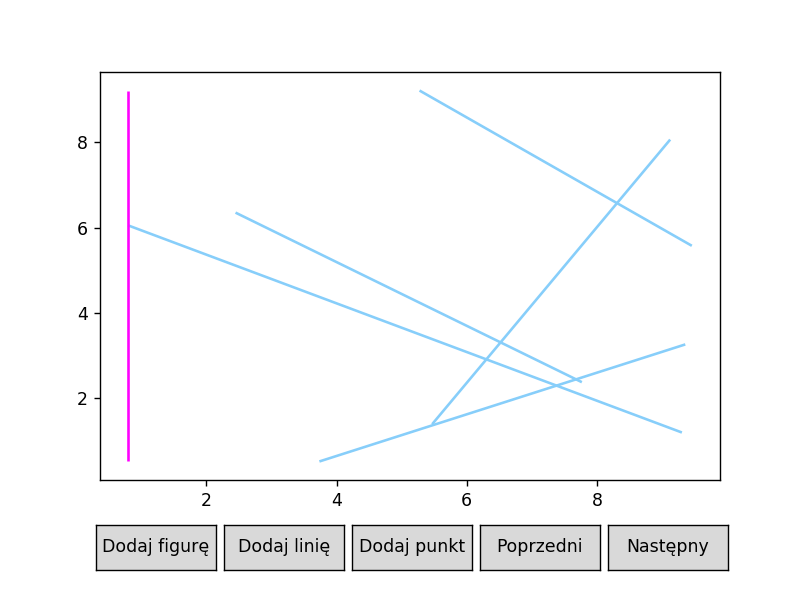

In [40]:
listOfLines = [[(5.469213265942593, 1.3936634976552709), (9.12481961359646, 8.065867389300015)],
[(5.27530167768322, 9.21545885591907), (9.457173710897276, 5.5762014809850875)],
[(2.4492030280207677, 6.353353413718593), (7.768266091349684, 2.3784704051570724)],
[(0.8003788674291379, 6.0536614701705895), (9.304761440956957, 1.1987537979704943)],
[(3.7372765510268415, 0.5200922875894587), (9.356755605600354, 3.263738392338975)]]
lineObj = [Line(line) for line in listOfLines]
lines = filterLines(lineObj)


plot = Plot(whereLinesCrossShow(lines))
plot.draw()

## Punkt 9 - testy


In [33]:

lineSets = [[[(-1, 0), (2, -1)], [(1, 3), (3, 4)], [(0, 2), (5, 1)], [(4, 1), (6,3)]],   #set 0 - test of detecting intersection
            [[(0.1648755695254739, 0.6818625759446579), (0.884550283922318, 0.7363195762883455)],
[(0.11867841156267278, 0.9815784029690111), (0.5069679280153371, 0.3945139252176958)],
[(0.5612640903239654, 0.07959777894597009), (0.9638146992047448, 0.5000080641633179)],
[(0.4280661403433207, 0.6138165709301864), (0.4967195453541128, 0.7538794955095615)],
[(0.1360030713110577, 0.028421305175576728), (0.7477883053304666, 0.9925330899880785)]],  #set 1 - random 5 lines
           [[(0.1191028225806452, 0.3231822032554477), (0.3719254032258065, 0.5017973993338791)],
[(0.19228830645161293, 0.5658292620789773), (0.5737399193548388, 0.319812105216232)],
[(0.3209173387096774, 0.3703635758044674), (0.6158770161290323, 0.5051674973730949)],
[(0.5781754032258065, 0.7747753405103497), (0.9285786290322581, 0.5927900463927027)],
[(0.5382560483870968, 0.6231209287456438), (0.8243447580645161, 0.7781454385495654)],
[(0.46063508064516134, 0.48494690913780075), (0.6890625, 0.6197508307064281)],
[(0.8066028225806453, 0.5927900463927027), (0.9086189516129034, 0.3602532816868203)],
[(0.41184475806451615, 0.029983673843682945), (0.724546370967742, 0.4377655365887811)]    #set 2 - 10 drawn lines
],
          [ [(0.08583669354838713, 0.7309640660005459), (1.0106350806451614, 0.3703635758044674)],
[(-0.013961693548387083, 0.23892975227505558), (0.9795866935483871, 0.8354371052162322)],
[(0.12797379032258066, 0.48831700717701637), (0.3519657258064517, 0.5388684777652517)],
[(0.5959173387096774, 0.3231822032554477), (0.811038306451613, 0.933169948353487)],
[(0.7533770161290323, 0.2658905365887811), (0.9307963709677419, 0.933169948353487)]],
                                                                                           #set 3 - zajęcia - pierwszy zbiór
 [[(0.20914315869731293, 0.8017361248240753), (0.8877721909553774, 0.6366013209025065)],
[(0.15369961031021612, 0.4782067130593693), (0.7857560619231193, 0.34003269345152615)],
[(0.1492641264392484, 0.6736723993338791), (0.7791028361166678, 0.48831700717701637)],
[(0.2867641264392484, 0.2793709287456438), (0.4198286425682807, 0.9635008307064283)],
[(0.45974799740699035, 0.23892975227505558), (0.6172076748263452, 0.9399101444319184)],
[(0.7192238038586033, 0.2288194581574085), (0.8057157393424742, 0.9264297522750558)]]]  #set 4 - krata
             

lineClassList = [ filterLines([Line(line) for line in listOfLines]) for listOfLines in lineSets]

<IPython.core.display.Javascript object>


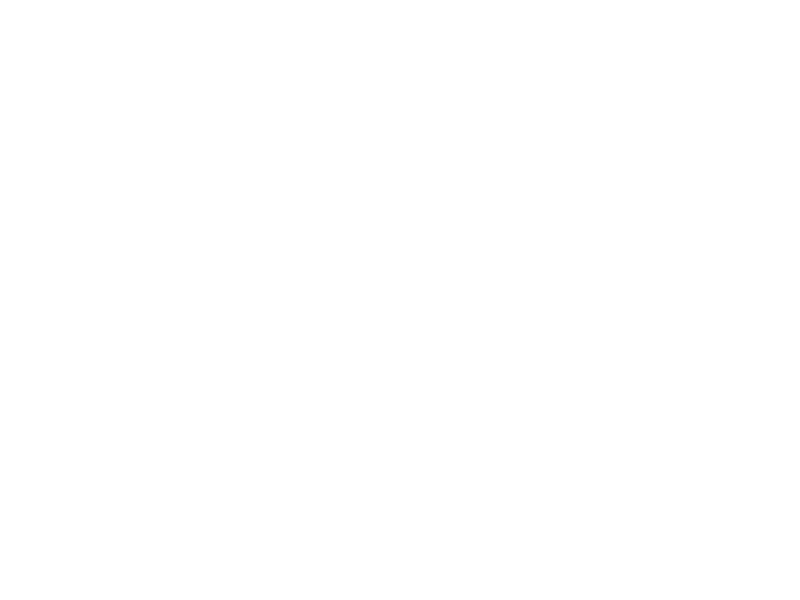

In [34]:
plot = Plot(whereLinesCrossShow(lineClassList[0]))
plot.draw()

<IPython.core.display.Javascript object>


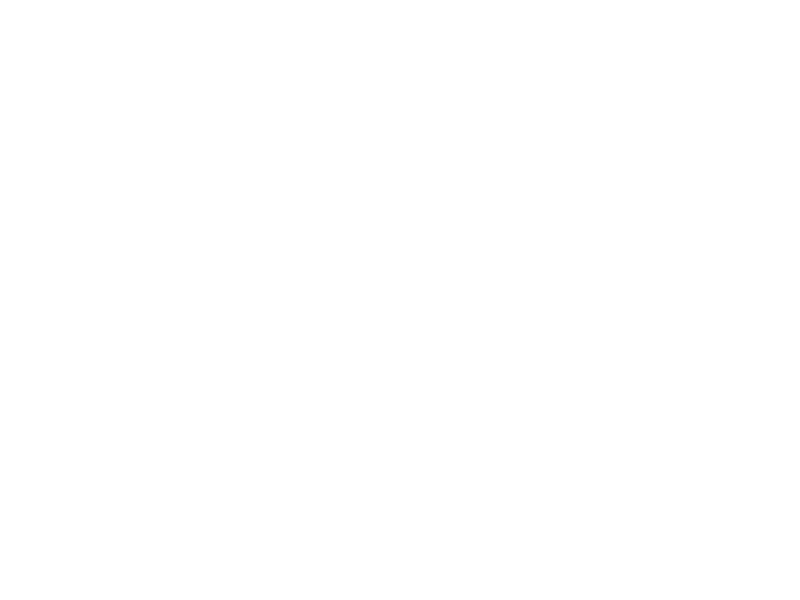

In [35]:
plot = Plot(whereLinesCrossShow(lineClassList[1]))
plot.draw()

<IPython.core.display.Javascript object>


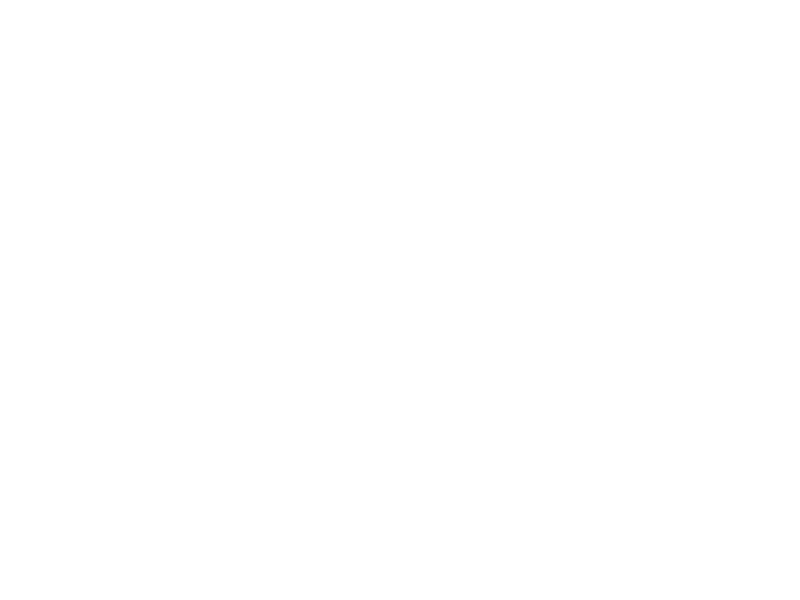

In [36]:
plot = Plot(whereLinesCrossShow(lineClassList[2]))
plot.draw()

<IPython.core.display.Javascript object>


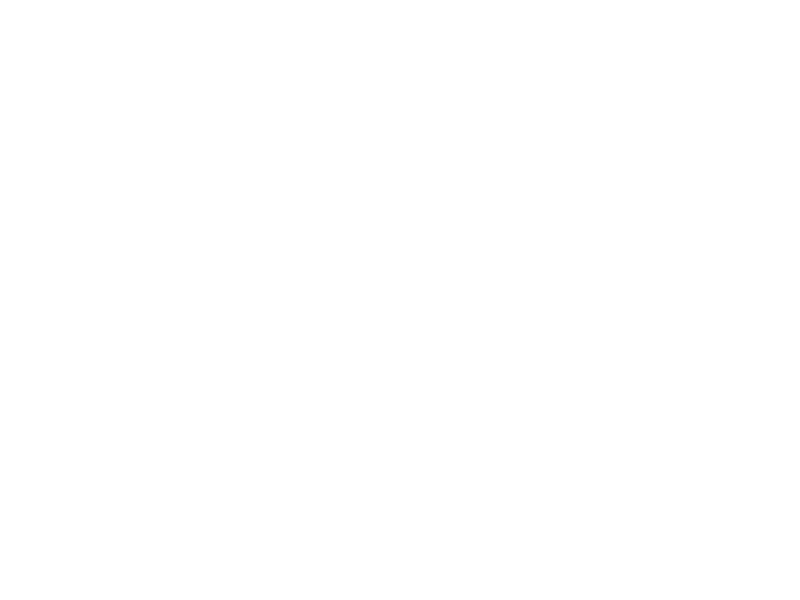

In [37]:
plot = Plot(whereLinesCrossShow(lineClassList[3]))
plot.draw()

<IPython.core.display.Javascript object>


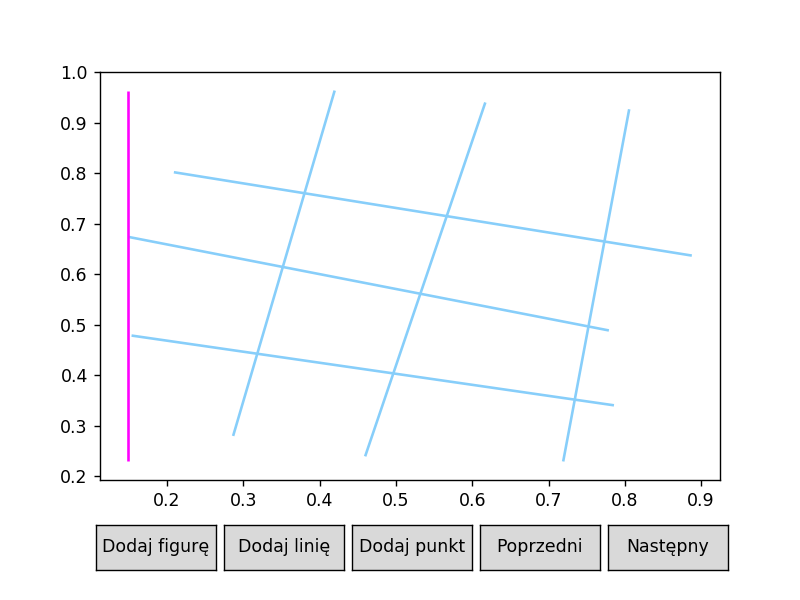

In [38]:
plot = Plot(whereLinesCrossShow(lineClassList[4]))
plot.draw()

## Punkt 10 - odcinki wykrywane wiecej niż jeden raz
Zastosowano tutaj przecięcie punktów, które są sprzeczne z naszymi wstępnymi założeniami, czyli >3 przecinające się w jednym punkcie

In [41]:
listOfLines = [[(-1, -1), (1, 1)],
               [(-2, 2), (2, -2)],
               [(-3, 5), (3, -5)]]
lineObj = [Line(line) for line in listOfLines]
lines = filterLines(lineObj)

intersections = whereLinesCross(lines)
print(intersections[0])
print()
for intersecPoint in intersections[1]:
    print(intersecPoint)
print()
for intersecLine in intersections[2]:
    print(intersecLine)

2

(0.0, 0.0)
(0.0, 0.0)

(((-2, 2), (2, -2)), ((-3, 5), (3, -5)))
(((-1, -1), (1, 1)), ((-2, 2), (2, -2)))


Jak widać program zwraca "podwójne" punkty, gdyż powtórzenia sprawdzane są na bazie linii.